In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords 

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [3]:
stemmed = pd.read_csv('stemmed.csv')

In [53]:
len(stemmed)

8675

In [54]:
text = stemmed['clean_posts']
code = stemmed['encode']
fixed_text = text[pd.notnull(text)]
fixed_code = code[pd.notnull(text)]
data = pd.DataFrame({'text': fixed_text, 'code': fixed_code})
len(data)

8651

In [55]:
data.to_csv("final.csv", encoding='utf-8', index=False)

## Try Naive Bayes once without cross validation 

In [73]:
train, test =  train_test_split(data, test_size=0.2, random_state=14)

In [100]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.text)
X_train_counts.shape

(6920, 92302)

In [73]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(6920, 92302)

In [74]:
clf = MultinomialNB().fit(X_train_tfidf, train.code)

In [75]:
train_predicted = clf.predict(X_train_tfidf)
np.mean(train_predicted == train.code) 

0.21343930635838151

In [76]:
X_test_counts = count_vect.transform(test.text)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
test_predicted = clf.predict(X_test_tfidf)
np.mean(test_predicted == test.code)  

0.21143847487001732

## Naive Bayes with Cross Validation
http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [2]:
data = pd.read_csv('final.csv')
print data.head()
# train test split
X_train, X_test, y_train, y_test= train_test_split(data.text, data.code, test_size=0.2, random_state=14)

   code                                               text
0     8  '<URL> <URL> enfp and intj moments  <URL>  spo...
1     3  'I'm finding the lack of me in these posts ver...
2    11  'Good one  _____   <URL> Of course, to which I...
3    10  'Dear INTP,   I enjoyed our conversation the o...
4     2  'You're fired. That's another silly misconcept...


In [7]:
np.random.seed(1)
scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 5000)

In [66]:
model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])
results_nb = cross_validate(model_nb, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)

In [91]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                          np.std(results_nb['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                          np.std(results_nb['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                          np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5424 (+/- 0.0073)
CV F1: 0.5424 (+/- 0.0073)
CV Logloss: 6.3304 (+/- 0.1587)


In [97]:
model_nb.fit(X_train, y_train)  
test_predicted = model_nb.predict(X_test)

0.54303870595031778

In [67]:
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

In [102]:
print(metrics.classification_report(y_test, test_predicted, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       0.55      0.26      0.35        47
       ENTP       0.42      0.52      0.46       130
       INTP       0.46      0.49      0.47        45
       INTJ       0.49      0.49      0.49       169
       ENTJ       0.33      0.17      0.22         6
       ENFJ       0.00      0.00      0.00        11
       INFP       0.00      0.00      0.00         9
       ENFP       0.29      0.08      0.12        26
       ISFP       0.60      0.51      0.55       276
       ISTP       0.58      0.69      0.63       367
       ISFJ       0.58      0.57      0.57       223
       ISTJ       0.61      0.66      0.63       249
       ESTP       0.61      0.45      0.52        31
       ESFP       0.22      0.21      0.21        43
       ESTJ       0.67      0.38      0.48        42
       ESFJ       0.43      0.51      0.46        57

avg / total       0.54      0.54      0.54      1731



### account for class imbalance in naive bayes

In [71]:
# find class weights 
import collections
ctr = collections.Counter(data.code)
print("Frequency of the elements in the List : ",ctr)
freqs_2 = [190,671,230,685,42,48,39,89,1462,1928,1089,1301,166,270,204,337]
class_priors_2 = [float(x) / len(data) for x in freqs_2]
print class_priors_2

('Frequency of the elements in the List : ', Counter({9: 1828, 8: 1462, 11: 1301, 10: 1089, 3: 685, 1: 671, 15: 337, 13: 270, 2: 230, 14: 204, 0: 190, 12: 166, 7: 89, 5: 48, 4: 42, 6: 39}))
[0.021962778869494857, 0.07756328748121605, 0.02658652178938851, 0.07918159750317882, 0.004854930065888337, 0.005548491503872385, 0.004508149346896312, 0.01028782799676338, 0.16899780372211304, 0.22286440873887411, 0.12588140099410472, 0.1503872384695411, 0.019188533117558665, 0.031210264709282162, 0.023581088891457633, 0.038955034100104036]


In [70]:
model_nb_prior = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB(class_prior = class_priors_2))])

results_nb_prior = cross_validate(model_nb_prior, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)

print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb_prior['test_acc']),
                                                          np.std(results_nb_prior['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb_prior['test_f1_micro']),
                                                          np.std(results_nb_prior['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb_prior['test_neg_log_loss']),
                                                          np.std(-1*results_nb_prior['test_neg_log_loss'])))
model_nb_prior.fit(X_train, y_train)  
test_predicted_prior = model_nb_prior.predict(X_test)
print(metrics.classification_report(y_test, test_predicted_prior, target_names=unique_type_list))

CV Accuracy: 0.5424 (+/- 0.0075)
CV F1: 0.5424 (+/- 0.0075)
CV Logloss: 6.3320 (+/- 0.1589)
             precision    recall  f1-score   support

       INFJ       0.52      0.26      0.34        47
       ENTP       0.42      0.52      0.47       130
       INTP       0.47      0.49      0.48        45
       INTJ       0.50      0.50      0.50       169
       ENTJ       0.33      0.17      0.22         6
       ENFJ       0.00      0.00      0.00        11
       INFP       0.00      0.00      0.00         9
       ENFP       0.25      0.08      0.12        26
       ISFP       0.60      0.51      0.55       276
       ISTP       0.58      0.70      0.63       367
       ISFJ       0.58      0.57      0.57       223
       ISTJ       0.61      0.66      0.63       249
       ESTP       0.61      0.45      0.52        31
       ESFP       0.23      0.21      0.22        43
       ESTJ       0.67      0.38      0.48        42
       ESFJ       0.43      0.51      0.47        57

avg /

## Logistic Regression with Cross Validation

Logisitic regression, C = 1

In [21]:
model_lr_o = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced"))])
results_lr_o = cross_validate(model_lr_o, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr_o['test_acc']),
                                                          np.std(results_lr_o['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr_o['test_f1_micro']),
                                                          np.std(results_lr_o['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr_o['test_neg_log_loss']),
                                                          np.std(-1*results_lr_o['test_neg_log_loss'])))

CV Accuracy: 0.5775 (+/- 0.0077)
CV F1: 0.5775 (+/- 0.0077)
CV Logloss: 2.0927 (+/- 0.0383)


In [22]:
model_lr_o.fit(X_train, y_train)  
test_predicted_lr_o = model_lr_o.predict(X_test)
print(metrics.classification_report(y_test, test_predicted_lr_o, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       0.52      0.26      0.34        47
       ENTP       0.45      0.50      0.47       130
       INTP       0.45      0.47      0.46        45
       INTJ       0.55      0.49      0.52       169
       ENTJ       0.40      0.33      0.36         6
       ENFJ       0.00      0.00      0.00        11
       INFP       1.00      0.22      0.36         9
       ENFP       0.70      0.27      0.39        26
       ISFP       0.55      0.56      0.55       276
       ISTP       0.62      0.68      0.65       367
       ISFJ       0.55      0.56      0.55       223
       ISTJ       0.55      0.61      0.58       249
       ESTP       0.47      0.45      0.46        31
       ESFP       0.32      0.37      0.34        43
       ESTJ       0.65      0.40      0.50        42
       ESFJ       0.44      0.42      0.43        57

avg / total       0.55      0.54      0.54      1731



logistic regression with regularization strength C = 0.005

In [10]:
model_lr_only = LogisticRegression(class_weight="balanced", C=0.005)
model_lr = Pipeline([('tfidf1', tfidf2), ('lr', model_lr_only )])
results_lr = cross_validate(model_lr, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)

In [11]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                          np.std(results_lr['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                                          np.std(results_lr['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                          np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6568 (+/- 0.0036)
CV F1: 0.6568 (+/- 0.0036)
CV Logloss: 1.2993 (+/- 0.0109)


In [12]:
model_lr.fit(X_train, y_train)  
test_predicted_lr = model_lr.predict(X_test)

In [16]:
print(metrics.classification_report(y_test, test_predicted_lr, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       0.51      0.40      0.45        47
       ENTP       0.60      0.61      0.61       130
       INTP       0.42      0.56      0.48        45
       INTJ       0.68      0.62      0.65       169
       ENTJ       0.22      0.33      0.27         6
       ENFJ       0.08      0.09      0.09        11
       INFP       0.67      0.44      0.53         9
       ENFP       0.67      0.38      0.49        26
       ISFP       0.69      0.61      0.65       276
       ISTP       0.73      0.75      0.74       367
       ISFJ       0.68      0.67      0.68       223
       ISTJ       0.66      0.70      0.68       249
       ESTP       0.46      0.61      0.53        31
       ESFP       0.42      0.44      0.43        43
       ESTJ       0.63      0.62      0.63        42
       ESFJ       0.49      0.65      0.56        57

avg / total       0.65      0.64      0.64      1731



In [27]:
# l2 regularization 
model_lr_l2_only = LogisticRegression(class_weight="balanced", C=0.005, penalty = "l2")
model_lr_l2 = Pipeline([('tfidf1', tfidf2), ('lr', model_lr_l2_only)])
results_lr_l2 = cross_validate(model_lr_l2, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr_l2['test_acc']),
                                                          np.std(results_lr_l2['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr_l2['test_f1_micro']),
                                                          np.std(results_lr_l2['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr_l2['test_neg_log_loss']),
                                                          np.std(-1*results_lr_l2['test_neg_log_loss'])))
                                                          
                                                          
model_lr_l2.fit(X_train, y_train)  
test_predicted_lr_l2 = model_lr_l2.predict(X_test)
print(metrics.classification_report(y_test, test_predicted_lr_l2, target_names=unique_type_list))

CV Accuracy: 0.6568 (+/- 0.0036)
CV F1: 0.6568 (+/- 0.0036)
CV Logloss: 1.2993 (+/- 0.0109)
             precision    recall  f1-score   support

       INFJ       0.51      0.40      0.45        47
       ENTP       0.60      0.61      0.61       130
       INTP       0.42      0.56      0.48        45
       INTJ       0.68      0.62      0.65       169
       ENTJ       0.22      0.33      0.27         6
       ENFJ       0.08      0.09      0.09        11
       INFP       0.67      0.44      0.53         9
       ENFP       0.67      0.38      0.49        26
       ISFP       0.69      0.61      0.65       276
       ISTP       0.73      0.75      0.74       367
       ISFJ       0.68      0.67      0.68       223
       ISTJ       0.66      0.70      0.68       249
       ESTP       0.46      0.61      0.53        31
       ESFP       0.42      0.44      0.43        43
       ESTJ       0.63      0.62      0.63        42
       ESFJ       0.49      0.65      0.56        57

avg /

Compare coefficients after l2 to model_lr

In [28]:
model_lr_l2_only.coef_

array([[-0.00739501,  0.0098344 , -0.04395071, ...,  0.01750716,
        -0.00645795, -0.01776871],
       [ 0.01126405,  0.00780299, -0.0348618 , ..., -0.00593112,
        -0.00306147, -0.01587556],
       [-0.01415709,  0.00790119, -0.06750588, ..., -0.0218618 ,
        -0.00805412, -0.03408169],
       ..., 
       [ 0.04030511, -0.01040178, -0.02188338, ..., -0.01597301,
        -0.00132489,  0.06999554],
       [-0.02029069,  0.00659794, -0.04063186, ...,  0.01633387,
         0.00588759,  0.02858284],
       [-0.01769814, -0.02182906, -0.00814406, ..., -0.00023377,
         0.00501872, -0.01986842]])

In [29]:
# l1 regularization 
model_lr_l1_only = LogisticRegression(class_weight="balanced", C=0.005, penalty = "l1")
model_lr_l1 = Pipeline([('tfidf1', tfidf2), ('lr', model_lr_l1_only)])

results_lr_l1 = cross_validate(model_lr_l1, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr_l1['test_acc']),
                                                          np.std(results_lr_l1['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr_l1['test_f1_micro']),
                                                          np.std(results_lr_l1['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr_l1['test_neg_log_loss']),
                                                          np.std(-1*results_lr_l1['test_neg_log_loss'])))
                                                          
                                                          
model_lr_l1.fit(X_train, y_train)  
test_predicted_lr_l1 = model_lr_l1.predict(X_test)
print(metrics.classification_report(y_test, test_predicted_lr_l1, target_names=unique_type_list))


CV Accuracy: 0.6040 (+/- 0.0101)
CV F1: 0.6040 (+/- 0.0101)
CV Logloss: 1.7499 (+/- 0.0206)
             precision    recall  f1-score   support

       INFJ       0.60      0.45      0.51        47
       ENTP       0.57      0.54      0.56       130
       INTP       0.49      0.56      0.52        45
       INTJ       0.72      0.56      0.63       169
       ENTJ       0.17      0.50      0.25         6
       ENFJ       0.05      0.27      0.09        11
       INFP       0.13      0.56      0.21         9
       ENFP       0.45      0.54      0.49        26
       ISFP       0.66      0.56      0.60       276
       ISTP       0.66      0.70      0.68       367
       ISFJ       0.67      0.60      0.64       223
       ISTJ       0.64      0.61      0.63       249
       ESTP       0.45      0.55      0.49        31
       ESFP       0.40      0.49      0.44        43
       ESTJ       0.53      0.55      0.54        42
       ESFJ       0.53      0.54      0.53        57

avg /

In [43]:
print 'The dimension of the coefficient matrix is', model_lr_l1_only.coef_.shape
total =  model_lr_l1_only.coef_.shape[0] * model_lr_l1_only.coef_.shape[1]
print 'There are a total of',total, 'coefficients'

The dimension of the coefficient matrix is (16, 5000)
There are a total of 80000 coefficients


In [51]:
print 'The number of non-zero coefficients are', total - sum(x == 0 for row in model_lr_l1_only.coef_ for x in row)
print 'Percentage:', float((total - sum(x == 0 for row in model_lr_l1_only.coef_ for x in row)))/float(total) * 100, '%'

The number of non-zero coefficients are 276
Percentage: 0.345 %


## Tree based methods
http://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html

## ExtraTreeClassifier

In [115]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth=4, n_jobs = -1)
tsvd = TruncatedSVD(n_components=10)
model_etc = Pipeline([('tfidf1', tfidf2), ('tsvd1', tsvd), ('etc', etc)])

In [116]:
results_etc = cross_validate(model_etc, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)

In [117]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_etc['test_acc']),
                                                          np.std(results_etc['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_etc['test_f1_micro']),
                                                          np.std(results_etc['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_etc['test_neg_log_loss']),
                                                          np.std(-1*results_etc['test_neg_log_loss'])))

CV Accuracy: 0.2419 (+/- 0.0101)
CV F1: 0.2419 (+/- 0.0101)
CV Logloss: 2.2172 (+/- 0.0021)


In [118]:
model_etc.fit(X_train, y_train)  
test_predicted_etc = model_etc.predict(X_test)

In [119]:
print(metrics.classification_report(y_test, test_predicted_etc, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       0.00      0.00      0.00        47
       ENTP       0.00      0.00      0.00       130
       INTP       0.00      0.00      0.00        45
       INTJ       0.00      0.00      0.00       169
       ENTJ       0.00      0.00      0.00         6
       ENFJ       0.00      0.00      0.00        11
       INFP       0.00      0.00      0.00         9
       ENFP       0.00      0.00      0.00        26
       ISFP       0.45      0.05      0.09       276
       ISTP       0.24      0.98      0.38       367
       ISFJ       1.00      0.02      0.04       223
       ISTJ       0.29      0.21      0.24       249
       ESTP       0.00      0.00      0.00        31
       ESFP       0.00      0.00      0.00        43
       ESTJ       0.00      0.00      0.00        42
       ESFJ       0.00      0.00      0.00        57

avg / total       0.29      0.25      0.13      1731



## From Decision Tree Classifier

In [126]:
rf = DecisionTreeClassifier()
model_rf = Pipeline([('tfidf1', tfidf2), ('rf', rf)])
results_rf = cross_validate(model_rf, X_train, y_train, cv=kfolds, scoring=scoring, n_jobs=-1)

In [127]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_rf['test_acc']),
                                                          np.std(results_rf['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_rf['test_f1_micro']),
                                                          np.std(results_rf['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_rf['test_neg_log_loss']),
                                                          np.std(-1*results_rf['test_neg_log_loss'])))

CV Accuracy: 0.4619 (+/- 0.0152)
CV F1: 0.4619 (+/- 0.0152)
CV Logloss: 18.5373 (+/- 0.5327)


In [128]:
model_rf.fit(X_train, y_train)  
test_predicted_rf = model_rf.predict(X_test)

In [125]:
print(metrics.classification_report(y_test, test_predicted_rf, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       0.16      0.13      0.14        47
       ENTP       0.40      0.48      0.44       130
       INTP       0.14      0.09      0.11        45
       INTJ       0.50      0.43      0.46       169
       ENTJ       0.00      0.00      0.00         6
       ENFJ       0.00      0.00      0.00        11
       INFP       0.11      0.11      0.11         9
       ENFP       0.00      0.00      0.00        26
       ISFP       0.47      0.52      0.49       276
       ISTP       0.55      0.56      0.55       367
       ISFJ       0.47      0.47      0.47       223
       ISTJ       0.50      0.53      0.51       249
       ESTP       0.22      0.26      0.24        31
       ESFP       0.25      0.23      0.24        43
       ESTJ       0.32      0.24      0.27        42
       ESFJ       0.45      0.37      0.40        57

avg / total       0.44      0.45      0.45      1731



## Tune Random Forest Classifier using GridSearchCV

https://www.kaggle.com/hadend/tuning-random-forest-parameters

max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split

In [59]:
# tune depths of trees and max features 
max_features = ['auto', 'sqrt']
max_depth = np.arange(8,20,1)
parameters = {'rf__max_depth': max_depth,
              'rf__max_features': max_features}

In [60]:
rf = RandomForestClassifier(random_state = 84)
model_tune = Pipeline([('tfidf1', tfidf2), ('rf', rf)])

In [61]:
gs_rf =  GridSearchCV(model_tune, parameters, n_jobs=-1)

In [62]:
gs_results = gs_rf.fit(X_train, y_train)

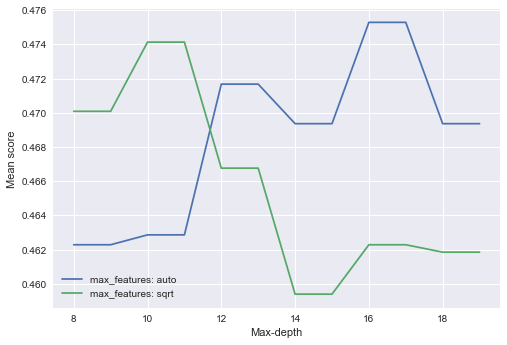

In [63]:
scores = [x[1] for x in gs_rf.grid_scores_]
scores = np.array(scores).reshape(len(max_features),len(max_depth))

for ind, i in enumerate(max_features):
    plt.plot(max_depth, scores[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('Max-depth')
plt.ylabel('Mean score')
plt.show()

In [65]:
rf_best = RandomForestClassifier(random_state = 84, max_depth = 16, max_features = 'auto')
model_rf_best = model_tune = Pipeline([('tfidf1', tfidf2), ('rf_best', rf_best)])
model_rf_best.fit(X_train, y_train)  
test_predicted_rf_best = model_rf_best.predict(X_test)

In [68]:
print(metrics.classification_report(y_test, test_predicted_rf_best, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       0.50      0.04      0.08        47
       ENTP       0.46      0.37      0.41       130
       INTP       0.30      0.07      0.11        45
       INTJ       0.56      0.39      0.46       169
       ENTJ       0.00      0.00      0.00         6
       ENFJ       0.00      0.00      0.00        11
       INFP       0.00      0.00      0.00         9
       ENFP       0.00      0.00      0.00        26
       ISFP       0.51      0.60      0.55       276
       ISTP       0.45      0.76      0.57       367
       ISFJ       0.49      0.43      0.46       223
       ISTJ       0.47      0.60      0.53       249
       ESTP       0.50      0.06      0.11        31
       ESFP       0.44      0.09      0.15        43
       ESTJ       0.00      0.00      0.00        42
       ESFJ       0.58      0.19      0.29        57

avg / total       0.46      0.48      0.44      1731



//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



## SVM 

In [8]:
from sklearn.linear_model import SGDClassifier
model_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None))])
model_svm.fit(X_train, y_train)  
predicted_svm = model_svm.predict(X_test)
np.mean(predicted_svm == y_test)  

0.65049104563835936

In [9]:
result_svm = cross_validate(model_svm, X_train, y_train, cv=kfolds, scoring='accuracy', n_jobs=-1)

In [92]:
# print(result_svm)
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(result_svm['test_score']),
                                                           np.std(result_svm['test_score'])))

CV Accuracy: 0.6234 (+/- 0.0301)


In [93]:
model_svm.fit(X_train, y_train)  
test_predicted_svm = model_svm.predict(X_test)

In [94]:
print(metrics.classification_report(y_test, test_predicted_svm, target_names=unique_type_list))

             precision    recall  f1-score   support

       INFJ       1.00      0.17      0.29        47
       ENTP       0.65      0.52      0.58       130
       INTP       0.64      0.40      0.49        45
       INTJ       0.71      0.60      0.65       169
       ENTJ       0.67      0.33      0.44         6
       ENFJ       0.00      0.00      0.00        11
       INFP       0.00      0.00      0.00         9
       ENFP       1.00      0.15      0.27        26
       ISFP       0.61      0.68      0.65       276
       ISTP       0.63      0.88      0.73       367
       ISFJ       0.68      0.70      0.69       223
       ISTJ       0.64      0.78      0.70       249
       ESTP       0.71      0.39      0.50        31
       ESFP       0.71      0.23      0.35        43
       ESTJ       0.73      0.38      0.50        42
       ESFJ       0.77      0.42      0.55        57

avg / total       0.66      0.65      0.63      1731



# Tune SVM with GridSearchcv

In [10]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
               'clf__alpha': (1e-2, 1e-3,1e-4,2e-4)}
gs_svm = GridSearchCV(model_svm, parameters, n_jobs=-1)

In [12]:
gs_svm = gs_svm.fit(X_train[:1500], y_train[:1500])

In [13]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))

clf__alpha: 0.001
vect__ngram_range: (1, 1)


### Turns out our original parameters were the best

# Examine the relationship between different predictors 
https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas

In [13]:
data = pd.read_csv('final.csv')
print data.head()
# train test split
X_train, X_test, y_train, y_test= train_test_split(data.text, data.code, test_size=0.2, random_state=14)

   code                                               text
0     8  '<URL> <URL> enfp and intj moments  <URL>  spo...
1     3  'I'm finding the lack of me in these posts ver...
2    11  'Good one  _____   <URL> Of course, to which I...
3    10  'Dear INTP,   I enjoyed our conversation the o...
4     2  'You're fired. That's another silly misconcept...


In [14]:
# correlation matrix for predictors 
tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 500)                         
X_train_tfidf = tfidf2.fit_transform(X_train)

In [15]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [16]:
df = pd.DataFrame(X_train_tfidf.todense())

In [17]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,2,0,0,0,1,...,0,0,5,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,1,...,1,0,0,0,0,0,5,0,0,1
3,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0


In [24]:
smallest_df = df.iloc[:, 0:5]

In [22]:
smaller_df = df.iloc[:,0:25]

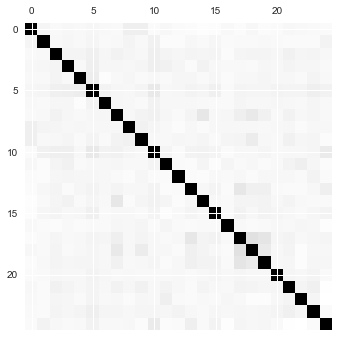

In [23]:
plt.matshow(smaller_df.corr())

## alternatively we can use sns

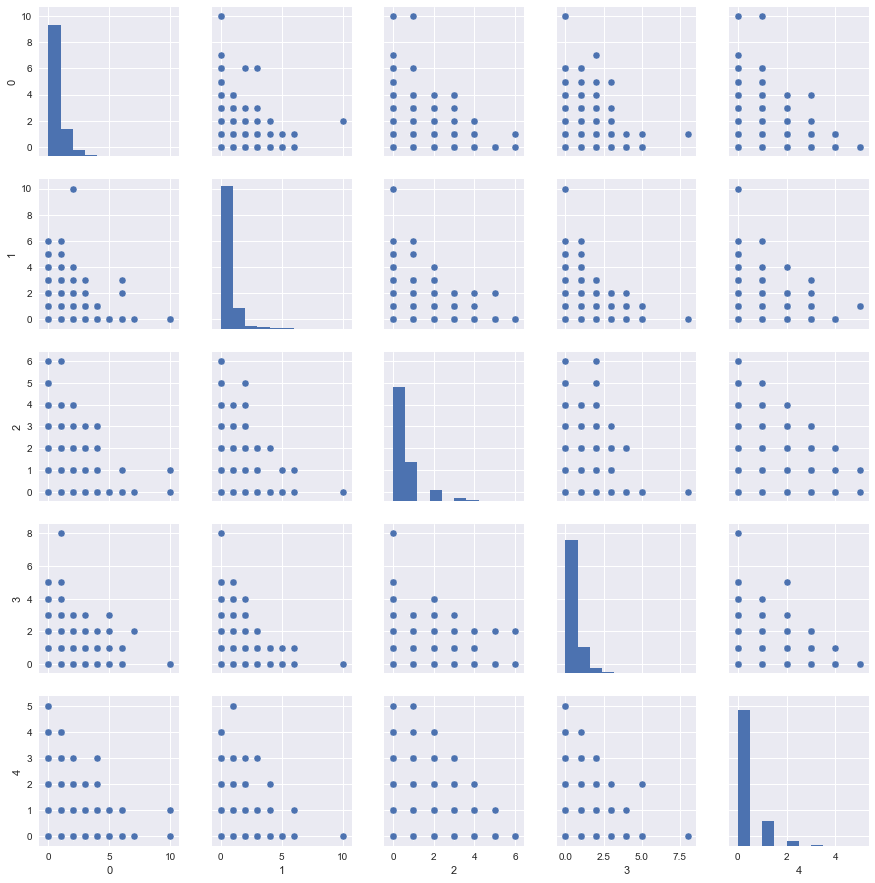

In [25]:
# alternative - sns
sns.pairplot(smallest_df)

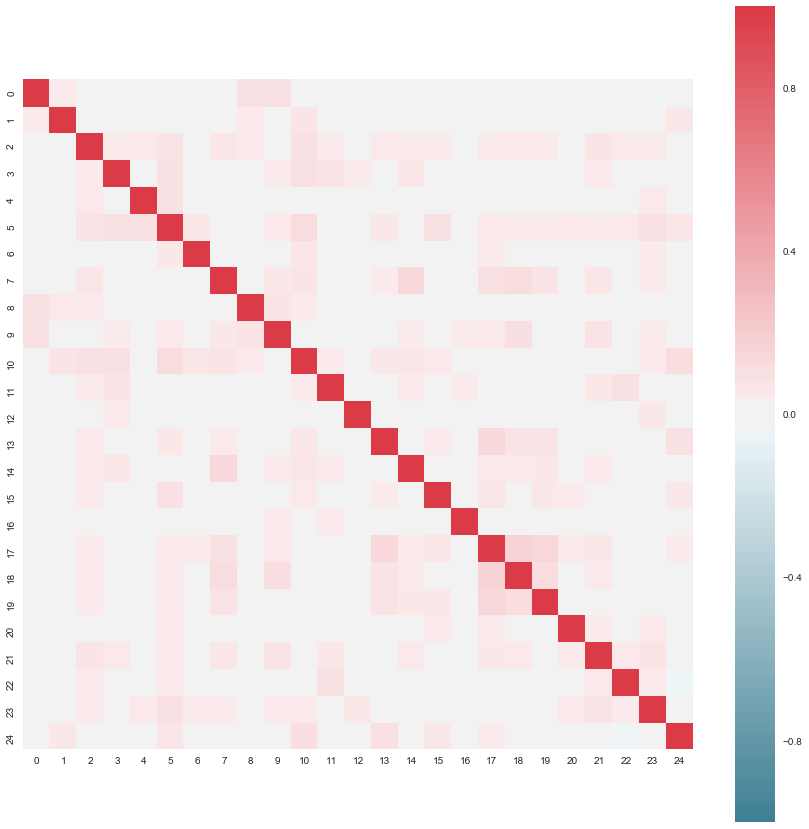

In [26]:
f, ax = plt.subplots(figsize=(15, 15))
corr = smaller_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [27]:
corr

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.043661,0.001329,0.017694,0.009781,0.031219,0.015456,0.004989,0.088919,0.087058,...,-0.022563,0.012119,-0.011923,0.021917,-0.009079,-0.002639,0.020856,0.012547,0.007587,-0.002931
1,0.043661,1.000000,0.017510,0.031503,0.014638,0.038380,0.006493,0.015729,0.048462,0.015281,...,0.036633,-0.006737,0.007125,0.002942,0.012930,0.005651,-0.000829,-0.005449,0.000681,0.055239
2,0.001329,0.017510,1.000000,0.046452,0.054053,0.085093,0.030350,0.066953,0.039332,0.025344,...,0.046600,-0.011650,0.041255,0.050178,0.046353,0.035242,0.073133,0.039556,0.046494,0.021562
3,0.017694,0.031503,0.046452,1.000000,0.013998,0.088294,0.035764,0.034060,0.018542,0.044301,...,0.028235,0.009475,0.015108,0.004017,0.031953,0.028377,0.052287,0.035882,0.032968,0.008445
4,0.009781,0.014638,0.054053,0.013998,1.000000,0.101242,-0.015109,0.011804,0.037034,0.001721,...,0.037899,-0.005659,0.022610,0.019447,0.039004,0.024612,0.020886,0.009068,0.053341,0.013704
5,0.031219,0.038380,0.085093,0.088294,0.101242,1.000000,0.055763,0.036506,0.024792,0.049890,...,0.086422,0.003003,0.049564,0.043279,0.044662,0.054281,0.046152,0.050613,0.091697,0.064376
6,0.015456,0.006493,0.030350,0.035764,-0.015109,0.055763,1.000000,0.031777,0.022722,0.007412,...,0.005027,0.008375,0.044060,0.025554,0.021271,0.029891,0.026613,0.011904,0.041961,0.010906
7,0.004989,0.015729,0.066953,0.034060,0.011804,0.036506,0.031777,1.000000,0.025618,0.059588,...,0.020127,0.035178,0.093438,0.123607,0.078659,0.011763,0.064710,0.019843,0.043513,0.010447
8,0.088919,0.048462,0.039332,0.018542,0.037034,0.024792,0.022722,0.025618,1.000000,0.075309,...,0.026087,0.026909,0.029547,0.019406,0.016365,0.029709,0.036245,-0.003103,0.019162,0.029480
9,0.087058,0.015281,0.025344,0.044301,0.001721,0.049890,0.007412,0.059588,0.075309,1.000000,...,0.009270,0.045927,0.047322,0.107658,0.020798,0.009783,0.078633,0.033683,0.039910,-0.007769
